In [1]:
# Connect to the Github Repository
! git clone https://github.com/ZhuYuqicheng/Deep-Learning-Lab-Time-Series.git
# set up the right directory path
%cd /content/Deep-Learning-Lab-Time-Series

Cloning into 'Deep-Learning-Lab-Time-Series'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 208 (delta 3), reused 19 (delta 2), pack-reused 185
Receiving objects: 100% (208/208), 221.51 MiB | 21.00 MiB/s, done.
Resolving deltas: 100% (123/123), done.
Checking out files: 100% (185/185), done.
/content/Deep-Learning-Lab-Time-Series


In [2]:
# import useful functions
from DataGeneration import GenerateHARData, GenerateHAPTData
from utils import ShowSegmentation, ShowPosturalTransitions, PlotTimeSeries, PlotLabelDist, FeatureSelection

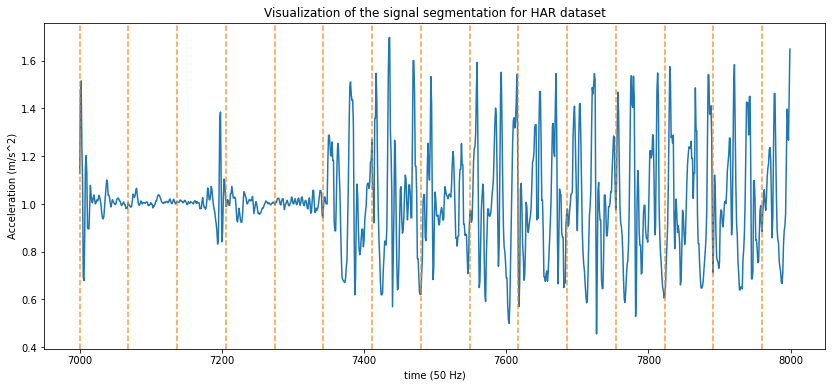

In [3]:
ShowSegmentation()

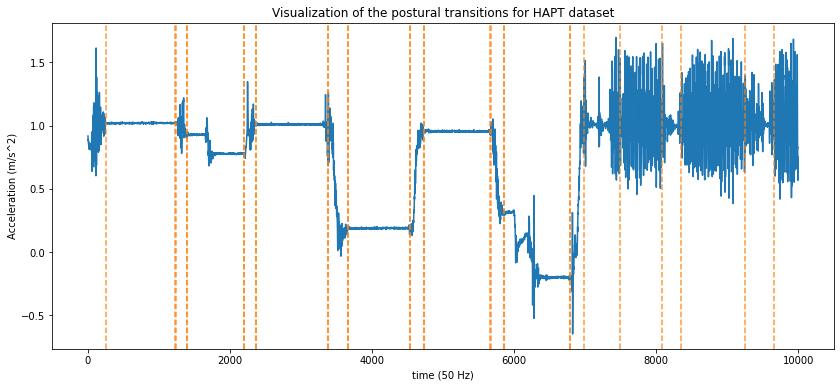

In [4]:
ShowPosturalTransitions()

In [5]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import time
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

In [6]:
# load the pre-processed time series data
# if you want to load HAPT dataset, just change the class to GenerateHAPTData
X, y = GenerateHARData().run()

In [7]:
from keras.layers.pooling.max_pooling1d import MaxPooling1D
from keras.layers.regularization.dropout import Dropout
from keras.layers.convolutional.conv1d_transpose import Conv1D
# define cnn model
def define_model(X, y, params):
  n_timesteps =  X.shape[1] # get dimension
  n_features = X.shape[2]
  n_outputs = y.shape[1]
  model = Sequential()  #model definition
  model.add(Conv1D(filters = int(params['Kernels1']), kernel_size= (int(params['kernel_size1'])), activation='relu', kernel_initializer='glorot_uniform', input_shape=(n_timesteps,n_features)))
  model.add(Conv1D(filters=int(params['Kernels1']), kernel_size=(int(params['kernel_size1'])), activation='relu'))           
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(units = int(params['units1']), activation='relu', kernel_initializer='he_uniform'))  #
  model.add(Dense(n_outputs, activation='softmax'))
  opt = SGD(lr=params['LR'], momentum=0.9)  # compile model
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [8]:
def evaluate_model(Model, X, y, n_folds):                                          #
	scores, histories = list(), list()
	# prepare cross validation
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(X):

		# select rows for train and test
		trainX, trainY, testX, testY = X[train_ix], y[train_ix], X[test_ix], y[test_ix]  #
		# fit model
		history = Model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = Model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# append scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

In [9]:
# Defining the hyper parameter space
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
#%% Hyper parameter tuning
param_hyperopt = {
    'LR': hp.loguniform('lr', np.log(0.001), np.log(1)),
    'Kernels1': hp.uniform('Kernels1', 16, 32),
    'kernel_size1': hp.quniform('kernel_size', 3, 7, 5),
    'units1': hp.quniform('units', 50, 200, 10)
    }
param_space = param_hyperopt

In [10]:
#%% Hyperopt function for 1D CNN 
def hyperopt(param_space, X, y, num_eval):
    
    start = time.time()
    
    def objective_function(params):
        clf = define_model(X, y, params)        
        scores, histories = evaluate_model(clf, X, y, n_folds = 5)
        score = np.mean(scores)
        return {'loss': -score, 'status': STATUS_OK}

    trials = Trials()
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(1))
    loss = [x['result']['loss'] for x in trials.trials]
    
    best_param_values = [x for x in best_param.values()]
    
    best_param_dic = {'LR' : best_param_values[2],
                     'Kernels1' : best_param_values[0],
                     'kernel_size1' : best_param_values[1],
                     'units1' : best_param_values[3]}
    
    clf_best = define_model(X, y, best_param_dic)
    
    clf_best.fit(X, y) #
    Y_pred = clf_best.predict(X) #
    Y_pred = np.rint(Y_pred)  #rounds elements of array to the nearest integer
    from sklearn.metrics import accuracy_score
    accuracy_score(y, Y_pred) #
    
    print("")
    print("##### Results")
    print("Score best parameters: ", min(loss)*-1)
    print("Best parameters: ", best_param)
    print("Test Score: ", accuracy_score(y, Y_pred))
    print("Time elapsed: ", time.time() - start)
    print("Parameter combinations evaluated: ", num_eval)
    
    return trials

In [11]:
# Hyper parameter tuning
num_eval = 50
results_hyperopt = hyperopt(param_hyperopt, X, y, num_eval)

  0%|          | 0/50 [00:00<?, ?it/s, best loss: ?]

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)



> 18.883
> 17.427
> 17.184
> 18.689
> 20.495
> 95.097
> 95.680
> 96.553
> 95.728
> 97.232
> 95.243
> 96.650
> 96.942
> 96.408
> 97.669
> 94.903
> 95.971
> 96.019
> 96.553
> 96.649
> 94.515
> 95.680
> 95.631
> 93.883
> 93.881
> 95.583
> 96.214
> 95.922
> 95.777
> 97.037
> 95.194
> 95.146
> 93.495
> 94.369
> 94.998
> 95.243
> 95.680
> 97.087
> 96.893
> 96.600
> 17.573
> 19.660
> 18.786
> 17.282
> 20.495
> 83.738
> 19.709
> 16.796
> 18.447
> 17.776
> 18.883
> 19.660
> 18.786
> 16.942
> 20.495
> 18.883
> 19.660
> 17.961
> 18.447
> 17.776
> 18.883
> 15.971
> 18.786
> 17.282
> 17.776
> 95.340
> 96.893
> 96.359
> 96.796
> 98.057
> 91.019
> 87.184
> 89.466
> 77.136
> 84.701
> 17.233
> 17.427
> 17.961
> 18.689
> 14.036
> 94.272
> 90.340
> 91.602
> 93.155
> 94.123
> 95.146
> 95.534
> 97.039
> 96.748
> 97.086
> 17.573
> 15.971
> 18.786
> 16.942
> 15.930
> 17.573
> 19.660
> 18.786
> 18.447
> 15.930
> 95.728
> 95.922
> 96.650
> 97.039
> 97.086
> 95.194
> 96.359
> 97.476
> 97.039
> 98.154
> 95.777
>